In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
path = r'C:\Users\aaron\Downloads\Month_Value_1.csv'

In [3]:
df = pd.read_csv(os.path.join(path), index_col = False)

In [4]:
df.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


In [5]:
data_2 = df.reset_index()

In [6]:
data_2.head()

,index,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


In [7]:
# Create a subset with the desired columns
data_sub = data_2[['Period', 'Average_cost']]

In [8]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Period'], format ='%d.%m.%Y') # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Period'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Average_cost
datetime,
2015-01-01,1257.763541
2015-02-01,1358.507000
2015-03-01,1384.697024
2015-04-01,1235.606705
2015-05-01,1626.621765


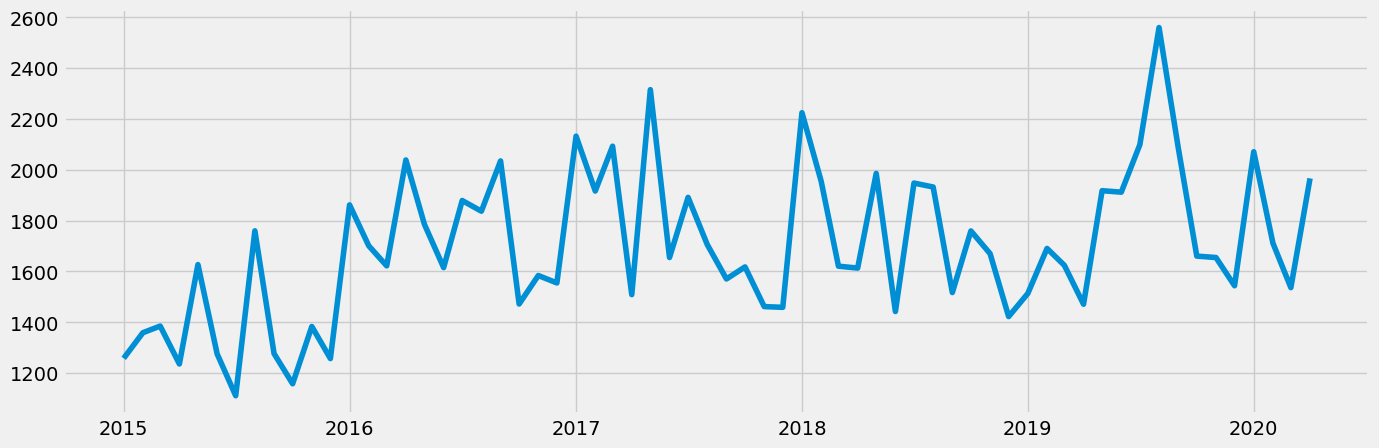

In [9]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

# Observation:
There seems to be a big seasonal component. It looks like there's an upward trend

In [10]:
# Check for missing values
data_sub.isnull().sum() 

Average_cost    32
dtype: int64

In [11]:
# Calculate the average (mean) of the 'Average_cost' column
average_cost = data_sub['Average_cost'].mean()

In [12]:
# Print the result
print("Average cost:", average_cost)

Average cost: 1695.0611591371598


In [13]:
data_sub['Average_cost'] = data_sub['Average_cost'].fillna(1695.0611591371598)


In [14]:
# Check for missing values
data_sub.isnull().sum() 

Average_cost    0
dtype: int64

In [15]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

31

# Decomposition

In [17]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='multiplicative')

In [18]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

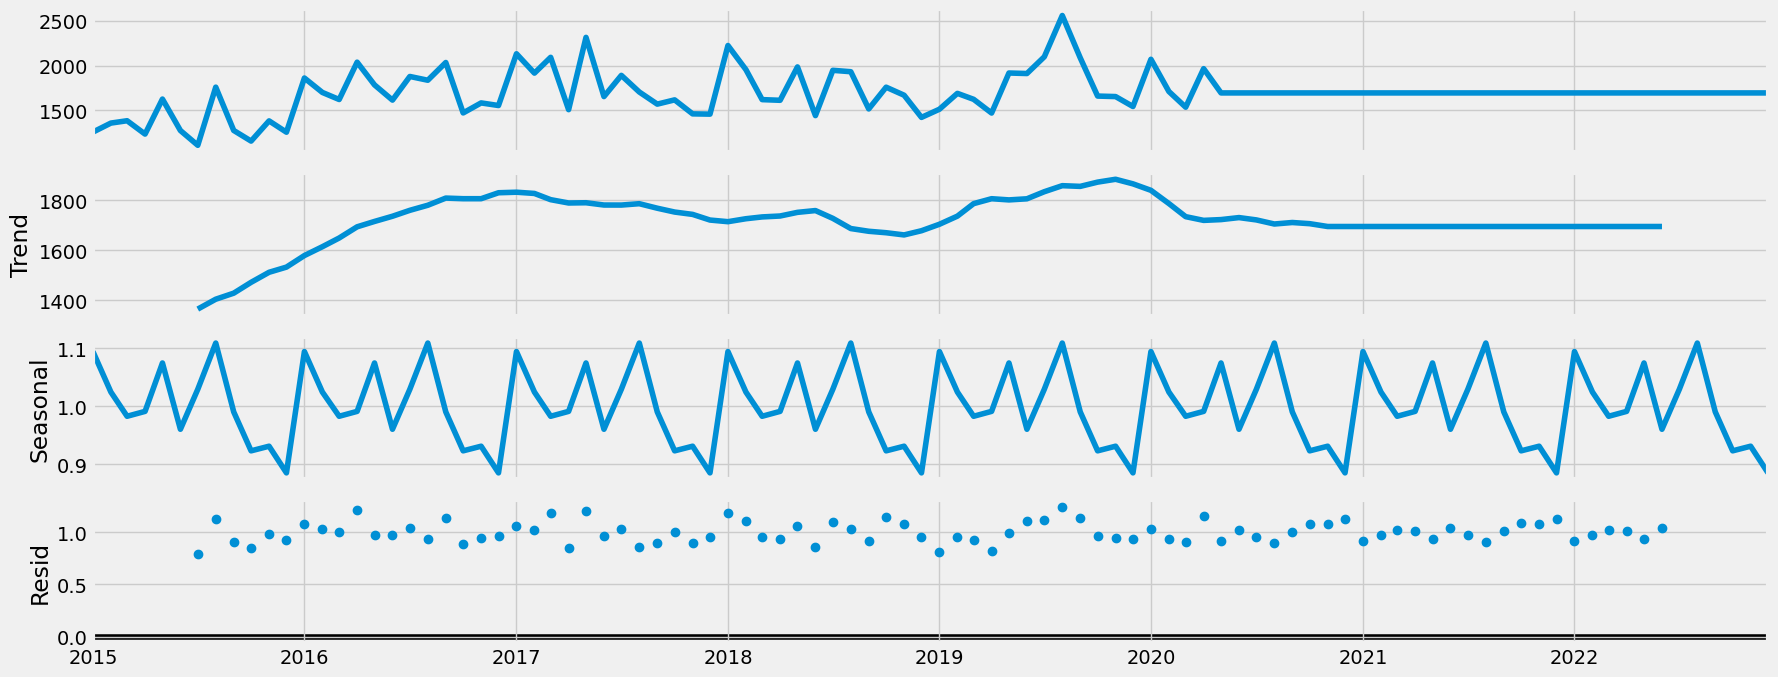

In [19]:
# Plot the separate components

decomposition.plot()
plt.show()

# Observations

There is a strong seasonality 

There is, indeed, an upward trend until 2017 then it kind of plateaus with a few minor peaks and valleys.


# Test for Stationarity

In [42]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Average_cost'])

Dickey-Fuller Stationarity test:
Test Statistic                -7.188693e+00
p-value                        2.536891e-10
Number of Lags Used            0.000000e+00
Number of Observations Used    9.500000e+01
Critical Value (1%)           -3.501137e+00
Critical Value (5%)           -2.892480e+00
Critical Value (10%)          -2.583275e+00
dtype: float64


# Interpretation of the Dickey-Fuller Stationarity test:
Our Test Statistic, -7.188693, is smaller than the 10% and 5% critical value, which means that we can reject the null hypothesis (which is: the data is not stationnary) with a certitude of 95%. Our p-value is less than 0.05, which means that the result is significant. We can consider the series stationnary.

# Check for autocorrelations

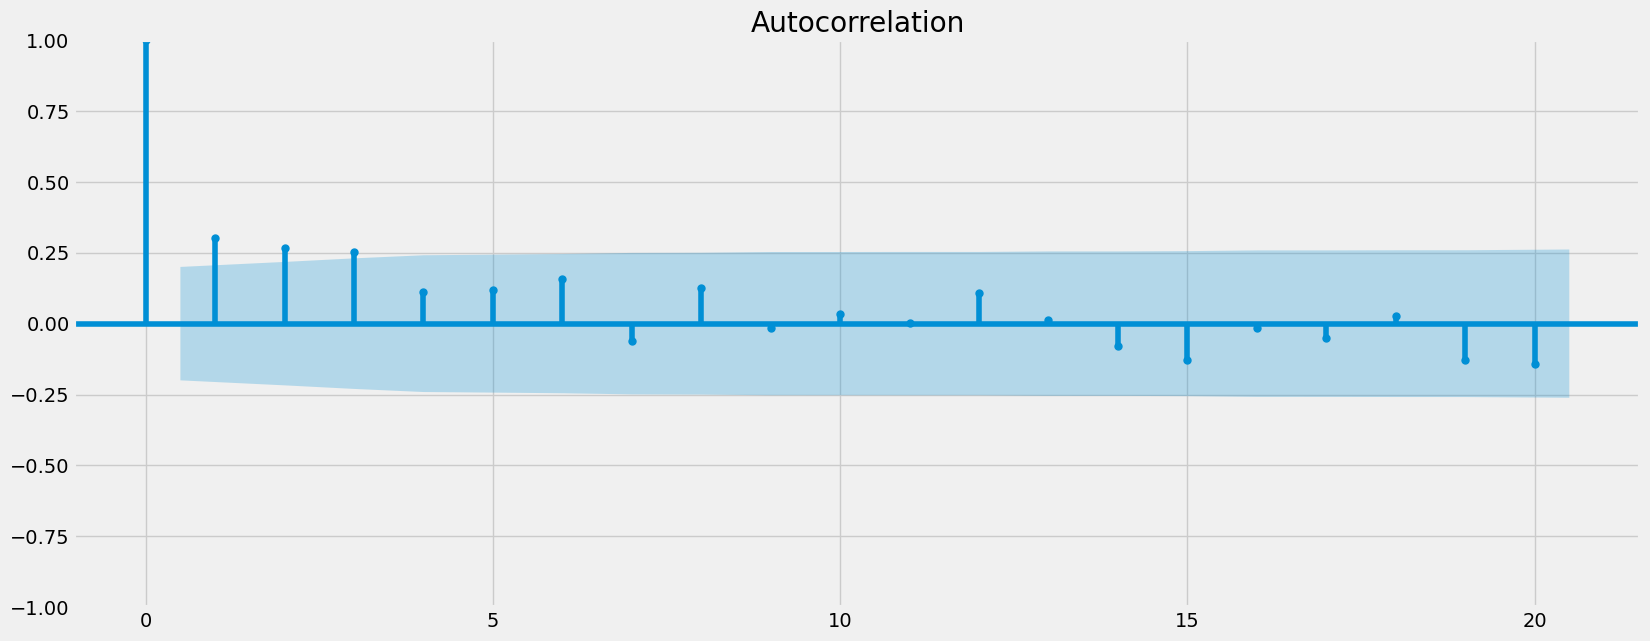

In [48]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_sub)
plt.show()

# Interpretation
We have 4 lags that are above the confidence interval, which means the data is not perfectly stationnary. It is, however, a small enough number of lags, and no differencing is necessary.